In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.layers import LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization

In [2]:
! pip install mplfinance
! pip install pandas_ta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=0ffb4f865cc0a4b903867218cd51fc587c3339a33cde87b3089e6bde6eff2c91
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:

df = pd.read_csv('/kaggle/input/eurusd60/EURUSD-60-DS.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45768,1.45785,12957.8500
1,01.01.2008 03:00:00.000,1.45788,1.45803,1.45754,1.45770,8374.1500
2,01.01.2008 04:00:00.000,1.45770,1.45987,1.45766,1.45913,11715.2595
3,01.01.2008 05:00:00.000,1.45916,1.45946,1.45854,1.45893,20694.8375
4,01.01.2008 06:00:00.000,1.45973,1.45984,1.45892,1.45962,26844.9970


In [5]:
import pandas_ta  as ta

df['ema_14'] = df.ta.ema(14)
df['MA20'] = df['Close'].rolling(window=40).mean()  # محاسبه MA20
correlation = df[['Close', 'MA20']].corr()
print(correlation)
df['sma_14'] = df.ta.sma(14)
df['trima_14'] = df.ta.trima(14)
df['rsi_14'] = df.ta.rsi(14)
df['atr_14'] = df.ta.atr(length=14)

df['obv'] = df.ta.obv()
df['adx_14'] = df.ta.adx(length=14)['ADX_14']

macd = df.ta.macd(fast=12, slow=26, signal=9)
df = pd.concat([df, macd], axis=1)

bb = df.ta.bbands(length=14)  # Default window of 20
df = pd.concat([df, bb], axis=1)

stoch = df.ta.stoch(k=14, d=3)
df = pd.concat([df, stoch], axis=1)

df['close_open_diff'] = df['Close'] - df['Open']
df['high_low_diff'] = df['High'] - df['Low']
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))


df['std_20'] = df['Close'].rolling(window=20).std()
df['std_60'] = df['Close'].rolling(window=60).std()

df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S.%f')
df['hour'] = df['Date'].dt.hour
df['day_of_week'] = df['Date'].dt.dayofweek
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] /  24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df['cci_14'] = df.ta.cci(length=14)

df['willr_14'] = df.ta.willr(length=14)
df['momentum_14'] = df['Close'] - df['Close'].shift(14)

#df['vwap'] = df.ta.vwap(high='High', low='Low', close='Close', volume='Volume')

df['body_ratio'] = np.abs(df['Close'] - df['Open']) / (df['High'] - df['Low'])
df['upper_shadow'] = df['High'] - df[['Open', 'Close']].max(axis=1)
df['lower_shadow'] = df[['Open', 'Close']].min(axis=1) - df['Low']
df = df.dropna()

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_14', 'sma_14',
       'trima_14', 'rsi_14', 'atr_14', 'obv', 'adx_14', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_14_2.0', 'BBM_14_2.0',
       'BBU_14_2.0', 'BBB_14_2.0', 'BBP_14_2.0', 'STOCHk_14_3_3',
       'STOCHd_14_3_3', 'close_open_diff', 'high_low_diff', 'log_return',
       'std_20', 'std_60', 'hour', 'day_of_week', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'cci_14', 'willr_14', 'momentum_14', 'body_ratio',
       'upper_shadow', 'lower_shadow'],
      dtype='object')

In [9]:
df['MA20'] = df['Close'].rolling(window=20).mean()  # محاسبه MA20
correlation = df[['Close', 'MA20']].corr()
print(correlation)

          Close      MA20
Close  1.000000  0.999644
MA20   0.999644  1.000000


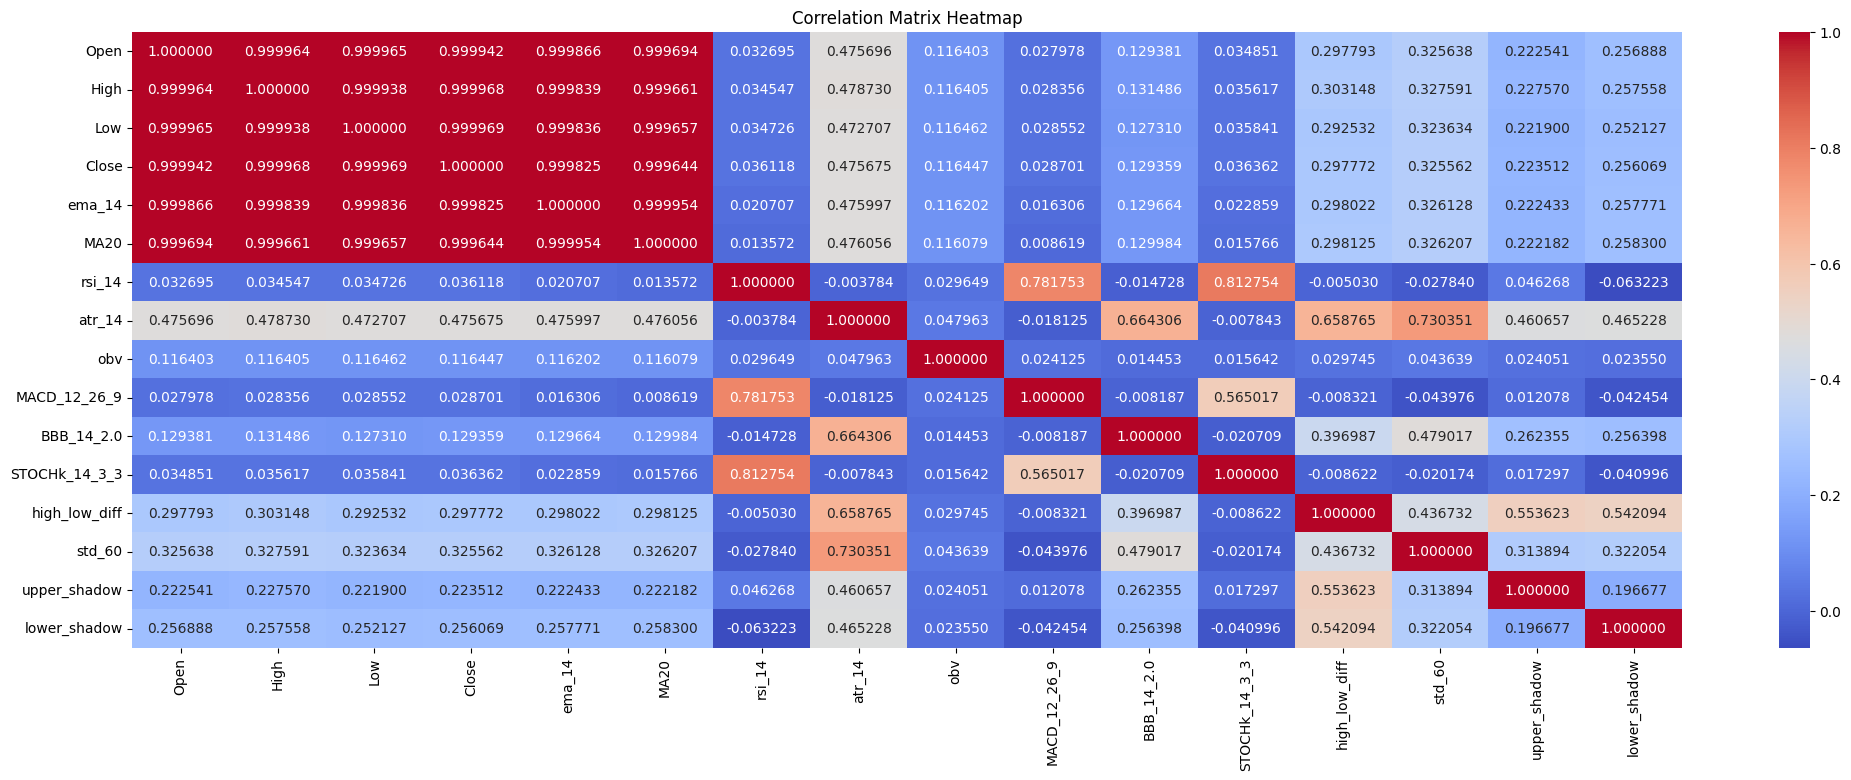

In [19]:
import seaborn as sns
correlation_matrix = df[['Open', 'High', 'Low', 'Close','ema_14','MA20','rsi_14','atr_14', 'obv','MACD_12_26_9','BBB_14_2.0','STOCHk_14_3_3','high_low_diff','std_60','upper_shadow', 'lower_shadow']].corr()
plt.figure(figsize=(25, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".6f")
plt.title('Correlation Matrix Heatmap')
plt.show()

In [24]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ema_14', 'sma_14',
       'trima_14', 'rsi_14', 'atr_14', 'obv', 'adx_14', 'MACD_12_26_9',
       'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_14_2.0', 'BBM_14_2.0',
       'BBU_14_2.0', 'BBB_14_2.0', 'BBP_14_2.0', 'STOCHk_14_3_3',
       'STOCHd_14_3_3', 'close_open_diff', 'high_low_diff', 'log_return',
       'std_20', 'std_60', 'hour', 'day_of_week', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'cci_14', 'willr_14', 'momentum_14', 'body_ratio',
       'upper_shadow', 'lower_shadow'],
      dtype='object')

In [10]:
input_features = ['Close','rsi_14','atr_14', 'obv','MACD_12_26_9','BBB_14_2.0','STOCHk_14_3_3','high_low_diff','std_60','upper_shadow', 'lower_shadow']
scalers_inputs = {col: MinMaxScaler() for col in input_features}
scaled_inputs = np.array([scalers_inputs[col].fit_transform(df[col].values.reshape(-1, 1)) for col in input_features])
scaled_inputs = np.transpose(scaled_inputs, (1, 0, 2))

# 3. انتخاب تارگت (OHLC)
output_features = ['Close']
scalers_outputs = {col: MinMaxScaler() for col in output_features}
scaled_outputs = np.array([scalers_outputs[col].fit_transform(df[col].values.reshape(-1, 1)) for col in output_features])
scaled_outputs = np.transpose(scaled_outputs, (1, 0, 2))

In [11]:
def create_sequences(inputs, outputs, seq_length):
    X, y = [], []
    for i in range(len(inputs) - seq_length):
        X.append(inputs[i:i + seq_length])
        y.append(outputs[i + seq_length])  # 4 مقدار OHLC تایم‌فریم بعدی
    return np.array(X), np.array(y)

seq_length = 128
X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length)

In [12]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 84622
تعداد نمونه‌های Validation: 10577
تعداد نمونه‌های Test: 10579


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# تعریف Time2Vector
class Time2Vector(tf.keras.layers.Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__(**kwargs)
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                             shape=(self.seq_len,),
                                             initializer='uniform',
                                             trainable=True)
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(self.seq_len,),
                                           initializer='uniform',
                                           trainable=True)
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(self.seq_len,),
                                                initializer='uniform',
                                                trainable=True)
        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(self.seq_len,),
                                             initializer='uniform',
                                             trainable=True)

    def call(self, x):
        x = tf.math.reduce_mean(x, axis=-1)  # میانگین روی همه فیچرها
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1)
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1)
        return tf.concat([time_linear, time_periodic], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], 2)

# تابع ترنسفورمر انکودر
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs
    
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Dense(ff_dim, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(inputs.shape[-1])(x)
    return x + res

# تعریف مدل
input_layer = Input(shape=(128, 11))
time_embedding = Time2Vector(seq_len=128)(input_layer)
concatenated = Concatenate()([input_layer, time_embedding])

x = transformer_encoder(concatenated, head_size=4, num_heads=3, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=4, num_heads=3, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=4, num_heads=3, ff_dim=128, dropout=0.1)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
out = Dense(1)(x)  # بدون activation برای پیش‌بینی پیوسته

model = Model(inputs=input_layer, outputs=out)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 11)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time2_vector              │ (None, 128, 2)         │            512 │ input_layer[0][0]      │
│ (Time2Vector)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 13)        │              0 │ input_layer[0][0],     │
│                           │                        │                │ time2_vector[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 128, 13)        │             26 │ concatenate[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 128, 13)        │            673 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 13)        │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 128, 13)        │              0 │ dropout_1[0][0],       │
│                           │                        │                │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 128, 13)        │             26 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128, 128)       │          1,792 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128, 13)        │          1,677 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 128, 13)        │              0 │ dense_1[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 128, 13)        │             26 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 128, 13)        │            673 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128, 13)        │              0 │ multi_head_attention_… │
├──────────────────────

 Total params: 14,055 (54.90 KB)

 Trainable params: 14,055 (54.90 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - loss: 0.0178 - mae: 0.0906 - val_loss: 0.0063 - val_mae: 0.0747
Epoch 2/100
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0032 - mae: 0.0420 - val_loss: 0.0034 - val_mae: 0.0541
Epoch 3/100
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0022 - mae: 0.0345 - val_loss: 0.0039 - val_mae: 0.0609
Epoch 4/100
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 0.0019 - val_mae: 0.0424
Epoch 5/100
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0013 - mae: 0.0258 - val_loss: 0.0017 - val_mae: 0.0390
Epoch 6/100
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0011 - mae: 0.0232 - val_loss: 0.0011 - val_mae: 0.0286
Epoch 7/100
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 9.2677e-04 - mae: 0.0217 - val_loss: 0.0019 - val_mae: 0.0412
Epoch 8/100
2645/2645 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 8.4498e-04 - mae: 0.0206 - val_loss: 0.0016 - val_mae: 0.0372
Epoch 9/100
264

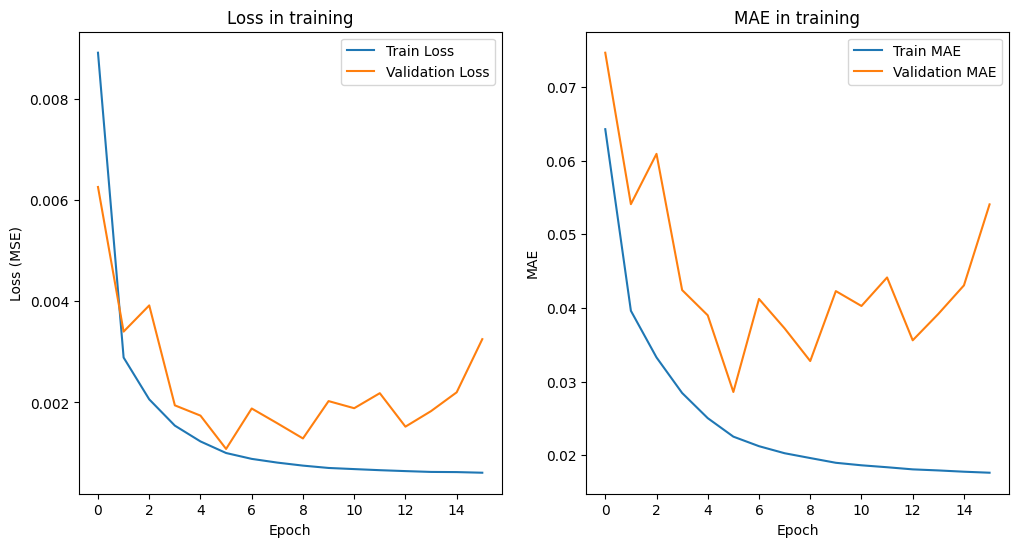

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

معیارهای ارزیابی برای Close:
MSE: 0.0048995543116830825
RMSE: 0.06999681643962875
MAE: 0.03398849989422193
R² Score: -16.33791334556054


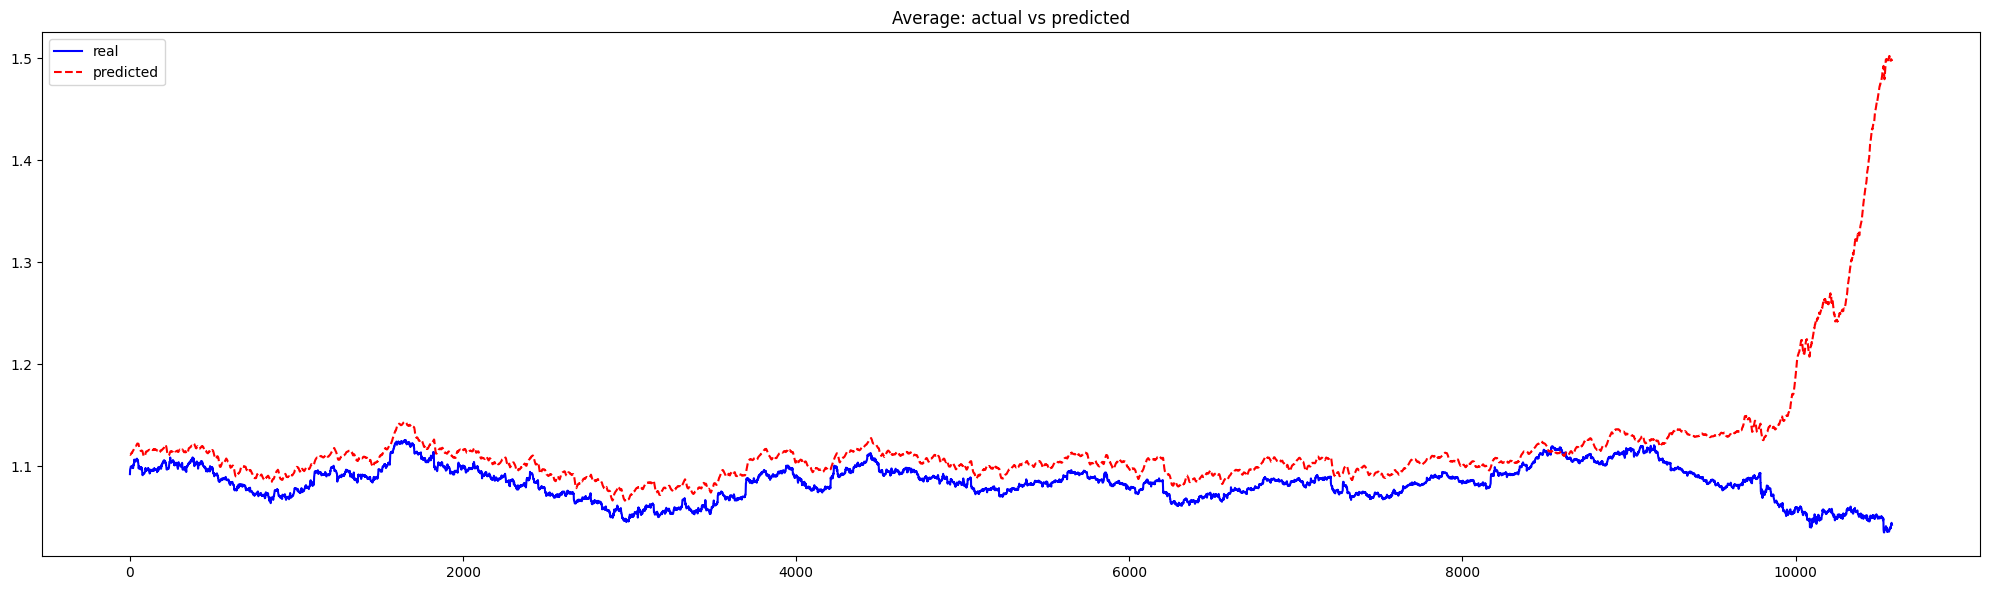

In [16]:
predictions = model.predict(X_test)

# 10. برگردوندن به مقیاس اصلی
predictions_average = scalers_outputs['Close'].inverse_transform(predictions[:, 0].reshape(-1, 1))


y_test_average = scalers_outputs['Close'].inverse_transform(y_test[:, 0].reshape(-1, 1))

# 11. محاسبه معیارها برای هر مقدار
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")

calculate_metrics(y_test_average, predictions_average, "Close")



# 13. رسم پیش‌بینی‌ها
plt.figure(figsize=(20, 6))
plt.subplot(1, 1, 1)
plt.plot(y_test_average, label='real', color='blue')
plt.plot(predictions_average, label='predicted', color='red',linestyle='--')
plt.title('Average: actual vs predicted')
plt.legend()



plt.tight_layout()
plt.show()

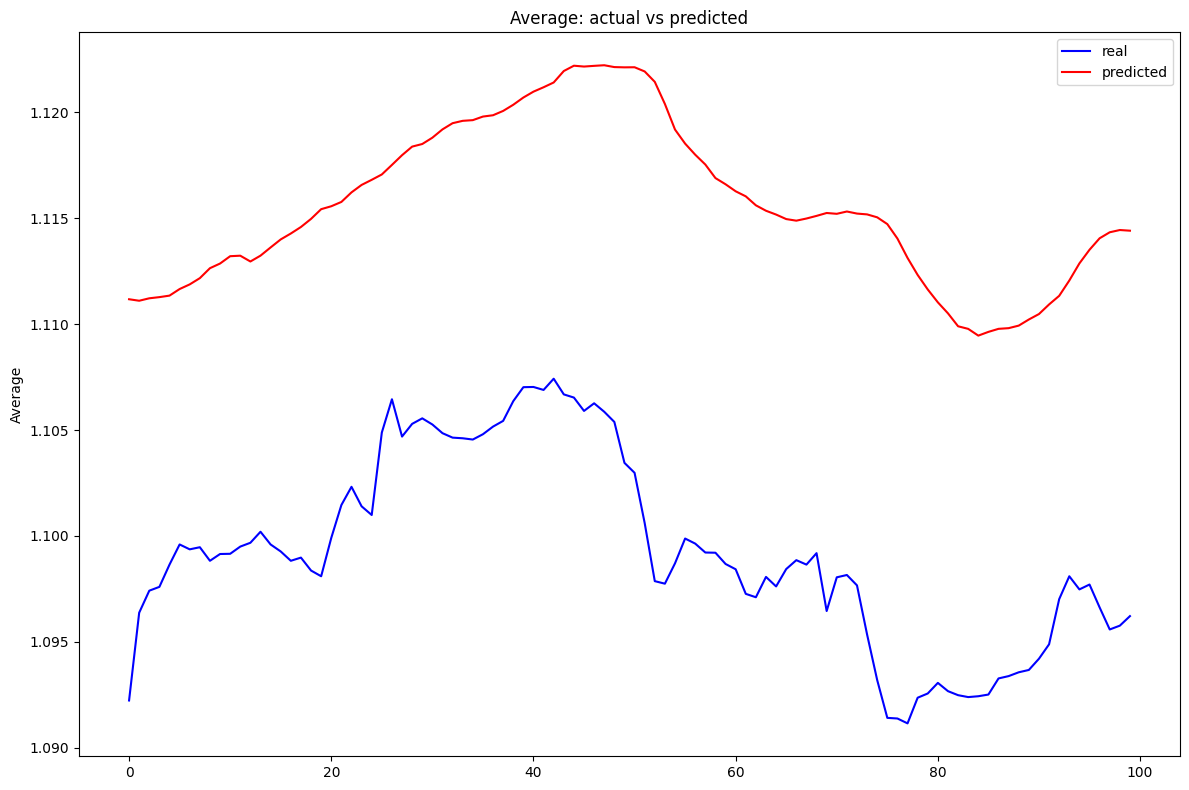

In [17]:
n_samples = 100  # تعداد نمونه‌هایی که می‌خوای نشون بدی

plt.figure(figsize=(12, 8))
plt.subplot(1, 1, 1)
plt.plot(y_test_average[:n_samples], label='real', color='blue')
plt.plot(predictions_average[:n_samples], label='predicted', color='red')
plt.title('Average: actual vs predicted')
plt.ylabel('Average')
plt.legend()



plt.tight_layout()
plt.show()

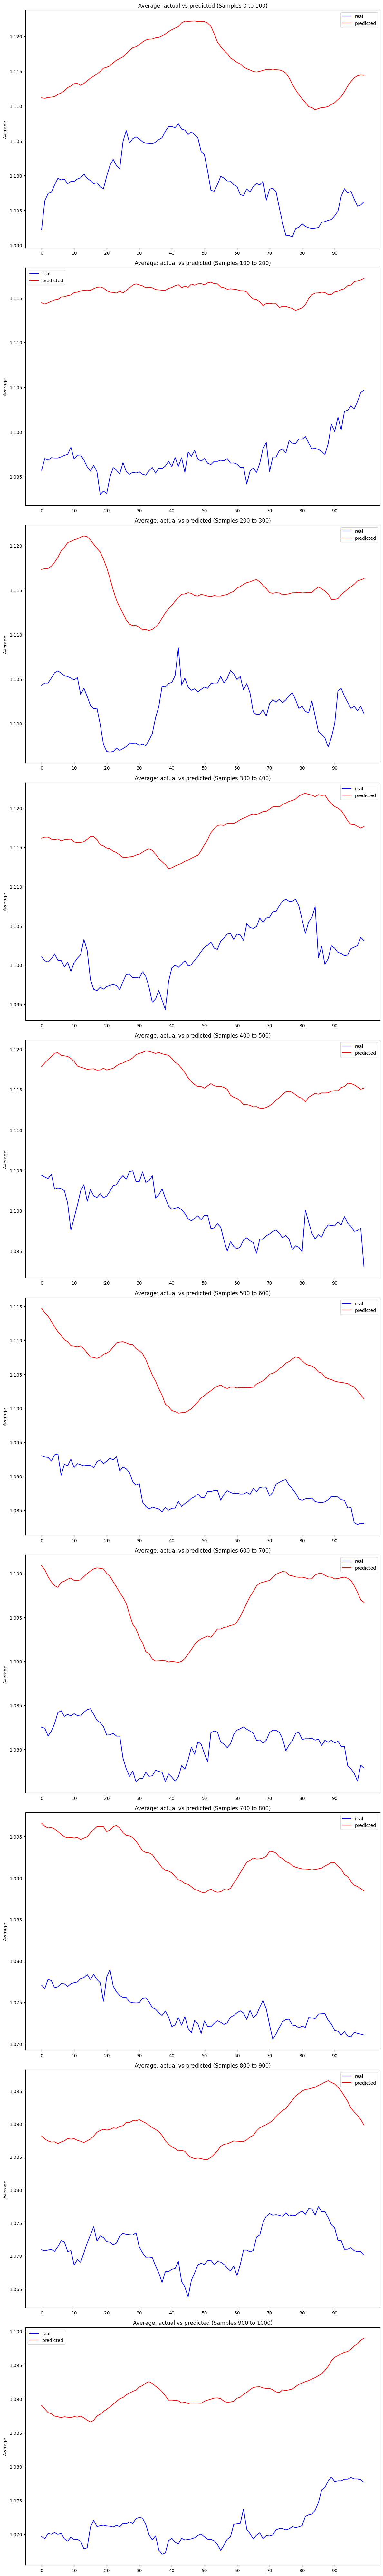

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# فرض می‌کنیم y_test_average و predictions_average آرایه‌های شما هستن
# y_test_average: مقادیر واقعی Average برای داده‌های تست
# predictions_average: مقادیر پیش‌بینی‌شده Average توسط مدل

# تعداد نمونه‌هایی که می‌خوای رسم کنی (1000 نمونه اول)
total_samples = 1000
n_samples_per_plot = 100  # تعداد نمونه‌ها در هر نمودار
n_plots = total_samples // n_samples_per_plot  # تعداد نمودارها (10)

# تنظیمات شکل کلی
plt.figure(figsize=(12, 8 * n_plots))  # ارتفاع شکل رو متناسب با تعداد نمودارها تنظیم می‌کنیم

# حلقه برای رسم 10 نمودار
for i in range(n_plots):
    # محاسبه بازه نمونه‌ها برای هر نمودار
    start_idx = i * n_samples_per_plot
    end_idx = (i + 1) * n_samples_per_plot
    
    # انتخاب داده‌ها برای این بازه
    y_test_subset = y_test_average[start_idx:end_idx]
    predictions_subset = predictions_average[start_idx:end_idx]
    
    # ایجاد زیرنمودار
    plt.subplot(n_plots, 1, i + 1)  # n_plots ردیف، 1 ستون، اندیس i+1
    
    # رسم خطوط
    plt.plot(y_test_subset, label='real', color='blue')
    plt.plot(predictions_subset, label='predicted', color='red')
    
    # اضافه کردن عنوان و لیبل‌ها
    plt.title(f'Average: actual vs predicted (Samples {start_idx} to {end_idx})')
    plt.ylabel('Average')
    plt.legend()
    
    # تنظیم محور x برای نمایش اندیس نمونه‌ها
    plt.xticks(np.arange(0, n_samples_per_plot, 10))  # تیک‌ها هر 10 نمونه

# تنظیمات نهایی و نمایش نمودار
plt.tight_layout()
plt.show()